# Chatbot Mejorado

###Notebook original "ES_Chatbot_bloom_17_12"

In [7]:
# Instalar la biblioteca de Hugging Face y spacy
!pip install transformers spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###0. https://github.com/bigscience-workshop/Megatron-DeepSpeed

Instalamos git, para poder trabajar con el repositorio bigscience-workshop

In [9]:
!git version

git version 2.17.1


In [15]:
!git init

Initialized empty Git repository in /content/.git/


In [16]:
!git config –global user.email “smirosarradell@gmail.com”
!git config –global user.name “silmir”

error: key does not contain a section: –global
error: key does not contain a section: –global


In [20]:
!git clone https://github.com/bigscience-workshop/Megatron-DeepSpeed
!cd Megatron-DeepSpeed
!pip install -r requirements.txt

Cloning into 'Megatron-DeepSpeed'...
remote: Enumerating objects: 11378, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 11378 (delta 32), reused 46 (delta 27), pack-reused 11304
Receiving objects: 100% (11378/11378), 6.77 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (8409/8409), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [21]:
!git clone https://github.com/NVIDIA/apex
!cd apex
!pip install --global-option="--cpp_ext" --global-option="--cuda_ext" --no-cache -v --disable-pip-version-check .  2>&1 | tee build.log

Cloning into 'apex'...
remote: Enumerating objects: 10686, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 10686 (delta 120), reused 123 (delta 64), pack-reused 10478
Receiving objects: 100% (10686/10686), 15.21 MiB | 26.71 MiB/s, done.
Resolving deltas: 100% (7346/7346), done.
Using pip 21.1.3 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/inclu

In [22]:
!git clone https://github.com/microsoft/deepspeed
!cd deepspeed
!rm -rf build
!TORCH_CUDA_ARCH_LIST="7.0" DS_BUILD_CPU_ADAM=1 DS_BUILD_AIO=1 DS_BUILD_UTILS=1 pip install -e . --global-option="build_ext" --global-option="-j8" --no-cache -v --disable-pip-version-check

Cloning into 'deepspeed'...
remote: Enumerating objects: 28043, done.
remote: Counting objects: 100% (3974/3974), done.
remote: Compressing objects: 100% (409/409), done.
remote: Total 28043 (delta 3762), reused 3646 (delta 3563), pack-reused 24069
Receiving objects: 100% (28043/28043), 33.21 MiB | 26.26 MiB/s, done.
Resolving deltas: 100% (20175/20175), done.
/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/

### 1.Tratamiento-Inclusión de datos de entrenamiento para FineTuning modelo

Transformamos datos originales (BOE) para ser tratados en modelo de Question-Answering, a modelo de generación de texto. Según especificado en repositorio github https://github.com/bigscience-workshop/Megatron-DeepSpeed:

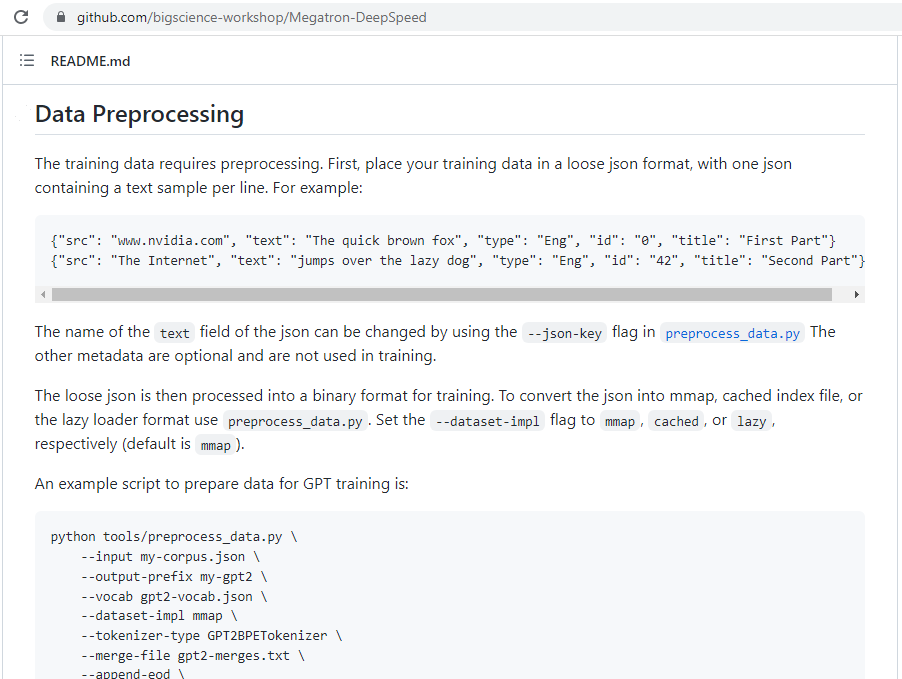

In [91]:
# Revisar documento tratamiento json y bdd original, para adaptar nombre del campo según la imagen anterior

In [92]:
import json
import requests
import random
import string

Leemos el fichero json del repositorio

In [93]:
url = "https://raw.githubusercontent.com/josuemzx/Chatbot-para-refugiados/main/data/Dataset%20propio/train_data.json"
train_data = json.loads(requests.get(url).text)

In [94]:
train_data

{'data': [{'paragraphs': [{'qas': [{'question': '¿Donde provienen las subvenciones?',
       'id': 583262,
       'answers': [{'answer_id': 642354,
         'document_id': 1173227,
         'question_id': 583262,
         'text': 'de la Secretaría General de Inmigración y Emigración, recibiendo cofinanciación, en algunos programas, del Fondo Social Europeo y del Fondo de Asilo, Migración e Integración.',
         'answer_start': 172,
         'answer_end': 346,
         'answer_category': None}],
       'is_impossible': False},
      {'question': '¿Para que sirven las subvenciones?',
       'id': 583263,
       'answers': [{'answer_id': 642355,
         'document_id': 1173227,
         'question_id': 583263,
         'text': 'para la acogida y la integración ',
         'answer_start': 38,
         'answer_end': 71,
         'answer_category': None}],
       'is_impossible': False},
      {'question': '¿Para quienes son las subvenciones?',
       'id': 583264,
       'answers': [{'answ

Buscamos que los datos queden en el formato especificado en la captura de pantalla de arriba: filtramos y cambiamos nombre de etiqueta de diccionario

In [95]:
#A continuación, filtramos un contexto (ejemplo)
train_data_context_0=train_data["data"][0]["paragraphs"][0]["context"]
train_data_context_0

'Las subvenciones concedidas a las ONG para la acogida y la integración de quienes conforman estos colectivos están financiadas con fondos que provienen de los presupuestos de la Secretaría General de Inmigración y Emigración, recibiendo cofinanciación, en algunos programas, del Fondo Social Europeo y del Fondo de Asilo, Migración e Integración.'

In [96]:
#Generamos nuevo diccionario con el formato especificado, aplicando el filtro del paso anterior

In [97]:
index1=int(0)+2
type(index1)
test=train_data["data"][index1]["paragraphs"][0]["context"]
test

'El Alto Comisionado de las Naciones Unidas para los Refugiados (ACNUR), organismo de las Naciones Unidas encargado de proteger a los refugiados y desplazados por persecuciones o conflictos, debe intervenir, de acuerdo con la legislación en vigor, en el procedimiento de concesión del derecho de asilo. En base a esta colaboración, el ACNUR recibe una subvención de la Dirección General de Migraciones.'

In [98]:
train_data_contexts=""
index1=int(0)

for i in train_data["data"]:
  train_data_contexts=train_data_contexts+'{"text": '+ train_data["data"][index1]["paragraphs"][0]["context"]+'}\n'
  index1=index1+1

print(train_data_contexts)

{"text": Las subvenciones concedidas a las ONG para la acogida y la integración de quienes conforman estos colectivos están financiadas con fondos que provienen de los presupuestos de la Secretaría General de Inmigración y Emigración, recibiendo cofinanciación, en algunos programas, del Fondo Social Europeo y del Fondo de Asilo, Migración e Integración.}
{"text": Centro de Acogida a Refugiados (C.A.R.). Son establecimientos públicos destinados a prestar alojamiento, manutención y asistencia psicosocial urgente y primaria, así como otros servicios sociales encaminados a facilitar la convivencia e integrar en la comunidad a las personas que solicitan asilo en España u obtengan la condición de refugiado o desplazado en España y que carezcan de medios económicos para atender a sus necesidades y a las de su familia.}
{"text": El Alto Comisionado de las Naciones Unidas para los Refugiados (ACNUR), organismo de las Naciones Unidas encargado de proteger a los refugiados y desplazados por perse

A partir de aquí la variable `train_data` tiene el mismo formato que el de github.

In [99]:
train_data=train_data_contexts
train_data

'{"text": Las subvenciones concedidas a las ONG para la acogida y la integración de quienes conforman estos colectivos están financiadas con fondos que provienen de los presupuestos de la Secretaría General de Inmigración y Emigración, recibiendo cofinanciación, en algunos programas, del Fondo Social Europeo y del Fondo de Asilo, Migración e Integración.}\n{"text": Centro de Acogida a Refugiados (C.A.R.). Son establecimientos públicos destinados a prestar alojamiento, manutención y asistencia psicosocial urgente y primaria, así como otros servicios sociales encaminados a facilitar la convivencia e integrar en la comunidad a las personas que solicitan asilo en España u obtengan la condición de refugiado o desplazado en España y que carezcan de medios económicos para atender a sus necesidades y a las de su familia.}\n{"text": El Alto Comisionado de las Naciones Unidas para los Refugiados (ACNUR), organismo de las Naciones Unidas encargado de proteger a los refugiados y desplazados por pe

###Vuelta al notebook original "ES_Chatbot_bloom_17_12"

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-1b1")
model = AutoModelForCausalLM.from_pretrained("bigscience/bloomz-1b1")

In [ ]:
!python -m spacy download es_core_news_sm
import es_core_news_sm
nlp = es_core_news_sm.load()

In [ ]:
# Definimos una función que procesa la respuesta del modelo y reemplaza las entidades nombradas por su descripción más detallada
def procesar_respuesta(respuesta):
  # Primero, procesamos la respuesta con spacy para detectar entidades nombradas
  doc = nlp(respuesta)

  # Luego, reemplazamos cada entidad nombrada por su descripción más detallada
  for ent in doc.ents:
    respuesta = respuesta.replace(ent.text, ent.description)

  # Finalmente, devolvemos la respuesta procesada
  return respuesta


In [ ]:
# Obtener la respuesta del modelo a la pregunta "¿...?"
input_text = "¿Por que el cielo es azul?"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
outputs = model.generate(input_ids)


In [ ]:
# Decodificar la respuesta del modelo y procesarla con la función procesar_respuesta
respuesta = tokenizer.decode(outputs[0])
respuesta_procesada = procesar_respuesta(respuesta)

# Mostrar la respuesta procesada en pantalla
print(respuesta_procesada)

###2.Guardar modelo entrenado en fichero

###Vuelta al notebook original "ES_Chatbot_bloom_17_12"

# Resultado:
Con el recurso disponible es es el mejor resultado que me dio.

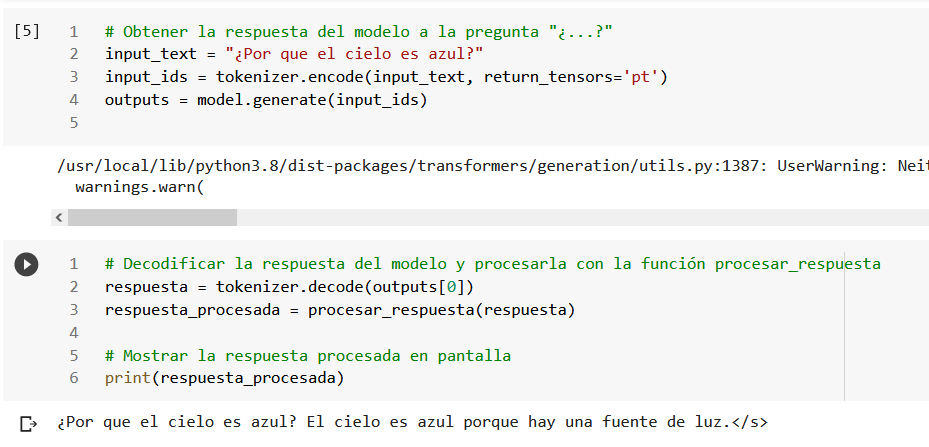

In [ ]:
# ***SM: Falta:
# 1.adaptar e incluir bdd, a considerar para el entrenamiento; y
# 2.añadir código para guardar el nuevo modelo